In [1]:
#importing all the required libraries

import pickle
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sbs
from sklearn.utils import shuffle
from keras.models import Sequential,load_model
from keras.layers import Conv2D, Flatten,Dense, MaxPooling2D,Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
import csv
from sklearn.metrics import confusion_matrix

In [2]:
#reading data from .csv file
data = pd.read_csv('D:/deep learning/traffic_signal_classification/signnames.csv')

In [3]:
#loading data
with open("D:/deep learning/traffic_signal_classification/traffic-signs-data/train.p", mode= 'rb') as train_data:
    train = pickle.load(train_data)
    
with open("D:/deep learning/traffic_signal_classification/traffic-signs-data/train.p",mode = 'rb') as test_data:
    test = pickle.load(test_data)
    
with open("D:/deep learning/traffic_signal_classification/traffic-signs-data/valid.p",mode= 'rb') as valid_data:
    valid = pickle.load(valid_data)

In [4]:
X_train, y_train = train['features'],train['labels']
X_test,y_test = test['features'],test['labels']
X_valid,y_valid = valid['features'],valid['labels']

In [5]:
with open('D:/deep learning/traffic_signal_classification/signnames.csv',newline='') as csvfile:
    reader = csv.reader(csvfile,delimiter=',')
    traffic_signs =[]
    for r in reader:
        traffic_signs.append(r[1])

In [6]:
#function to provide details on the dataset working on 
def dataset_info(X_train,X_valid,X_test,y_train):
    n_train = X_train.shape[0]
    n_valid = X_valid.shape[0]
    n_test = X_test.shape[0]
    img_shape = X_train[0].shape
    class_count = max(y_train)+1 
    print('Total training samples: ', n_train)
    print('TOtal valid samples: ',n_valid)
    print('Total test samples: ',n_test)
    print('Shape of Image : ', img_shape)
    print('Unique Class Count: ', class_count)

In [7]:
#data visualiyation    
def dataset_visualization(X_train,y_train,X_valid,y_valid,X_test,y_test):
    fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(20,5),sharex=True)
    class_count = int(max(y_train)+1)
    print('\nhistogram of traffic signs with frequency in dataset')
    msg = ['Training Dataset','Valid Dataset','Test Dataset']
    n_bins = class_count
    max_freq = 5
    n0, bins0, patches=ax0.hist(y_train, n_bins, facecolor='g', alpha=0.65)
    ax0.set_title(msg[0])
    ax0.set_ylabel('Frequency')

    n1, bins1, patches=ax1.hist(y_valid, n_bins, facecolor='b', alpha=0.65)
    ax1.set_title(msg[1])
    ax1.set_xlabel('Labels')

    n2, bins2, patches=ax2.hist(y_test, n_bins, facecolor='r', alpha=0.65)
    ax2.set_title(msg[2])

    fig.tight_layout()
    plt.show()

    sort_n0=np.argsort(n0,axis=-1)
    sort_n1=np.argsort(n1,axis=-1)
    sort_n2=np.argsort(n2,axis=-1)

    maxfreq_labels=[]
    maxfreq_labels=[sort_n0[class_count-max_freq:]]
    maxfreq_labels=np.append(maxfreq_labels,[sort_n1[class_count-max_freq:]],axis=0)
    maxfreq_labels=np.append(maxfreq_labels,[sort_n2[class_count-max_freq:]],axis=0)

    print("Traffic signs with more examples in datasets\n")

    for i,j in enumerate(maxfreq_labels):
        fig, ax = plt.subplots(ncols=max_freq, figsize=(15, 4))
        fig.tight_layout()
        for k in range(max_freq):
            val = j[max_freq-(1+k)]
            ind = np.max(np.where(y_valid==val))
            image = X_valid[ind].squeeze()
            ax[k].imshow(image, cmap="gray")
            ax[k].set_title('Label: '+ str(y_valid[ind]))
            ax[k].axis('off')
        fig.suptitle(msg[i])

In [19]:
#data pre-processing function
def Preprocessing(img_rgb):
    data_n = img_rgb.shape[0]
    imgs_gr = np.zeros((data_n,32,32,1))
    for i in range(data_n):
        
        temp_img = cv2.cvtColor(img_rgb[i],cv2.COLOR_RGB2GRAY)
        imgs_gr[i] = np.reshape(temp_img,(32,32,1))
        
    
    return imgs_gr




In [26]:
def img_aug(imgs_gr,labels):
    data_n = imgs_gr.shape[0]
    insts_p = np.zeros(class_count)
    for i in range(class_count):
        ints_sum = np.sum(labels==i)
        insts_p[i] = ints_sum/data_n
        
    aug = int(1.*data_n)
    aug_X = np.array(np.zeros((aug,32,32,1)))
    aug_y = np.array(np.zeros((aug)))
    for i in range(aug):
        indexing = random.randint(0,data_n-1)
        aug_X[i]=imgs_gr[indexing]
        aug_y[i]=lables[indexing]
        trigger = random.randint(1/np.max(insts_p),1/np.min(insts_p))
        while insts_p[int(aug-y[i])]*trigger>1.05:
            indexing = random.randint(0,data_n-1)
            aug_X[i]=imgs_gr[indexing]
            aug_y[i]=lables[indexing]
            insts_sum=np.sum(labels==aug_y[i])
            trigger = random.randint(1/np.max(insts_p),1/np.min(insts_p))
            
    
    for i in range(aug):
        n = radom.randint(2,4)
        r2 = radom.randint(-20,20)
        mat = cv2.getRotationMatrix2D((32/n,32/n),r2,1)
        temp = cv2.wrapAffine(aug_X[i],matm(32,32))
        
        noise = 10*np.random.randint((32,32))
        temp = temp + noise
        aug_X[i] = np.reshape(temp,(32,32,1))
    
    return aug_X,aug_y

def img_norm(imgs_gr):
    return (imgs_gr -128)/128

        

In [27]:
indexing = np.random.randint(1,len(X_train))
#shuffle training data to provide more randomness during training

X_train,y_train = shuffle(X_train,y_train)

#data preprocessing using our defined function
X_train_preprocessed = Preprocessing(X_train)

X_valid_preprocessed = Preprocessing(X_valid)

X_test_preprocessed = Preprocessing(X_test)


aug_X,aug_y = img_aug(X_train,y_train)
X_train_preprocessed = np.concatenate((X_train_preprocessed,aug_X))
y_train_preprocessed = np.concatenate((y_train_preprocessed,aug_y))

X_train_preprocessed = img_norm(X_train_preprocessed)
X_test_preprocessed = img_norm(X_train_preprocessed)




histogram of traffic signs with frequency in dataset


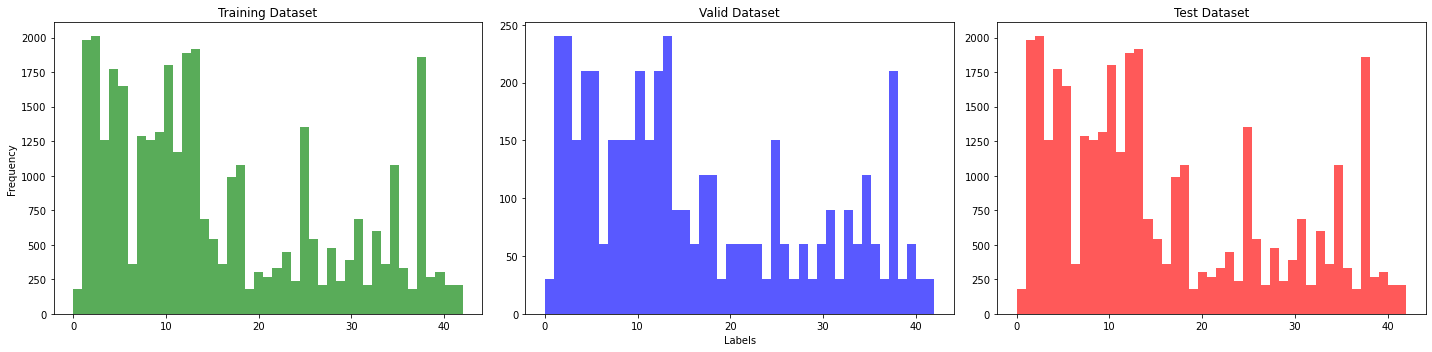

Traffic signs with more examples in datasets



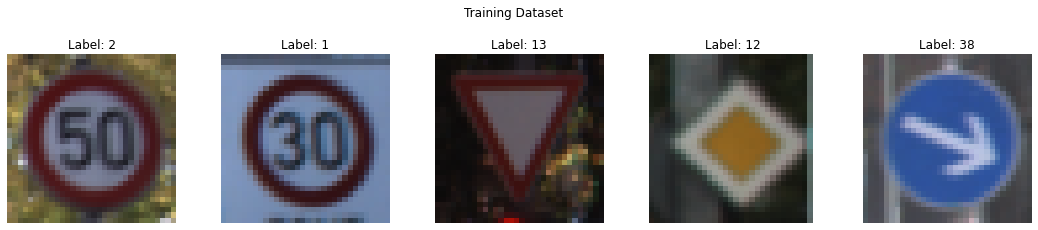

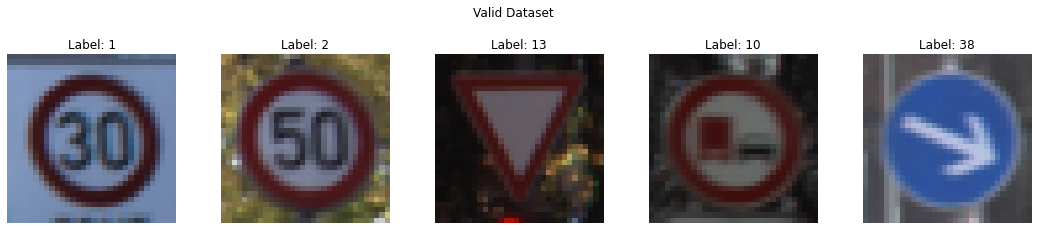

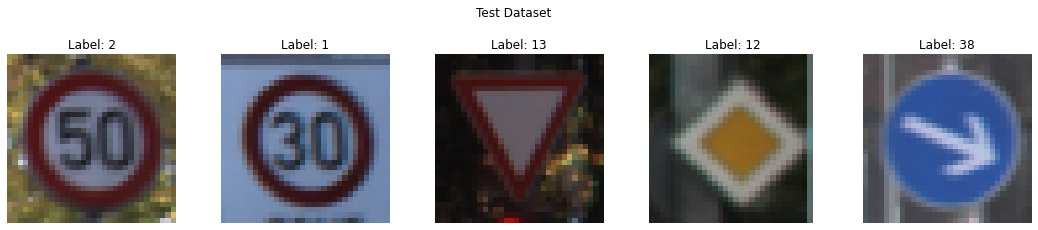

In [29]:
dataset_visualization(X_train,y_train,X_valid,y_valid,X_test,y_test)


histogram of traffic signs with frequency in dataset


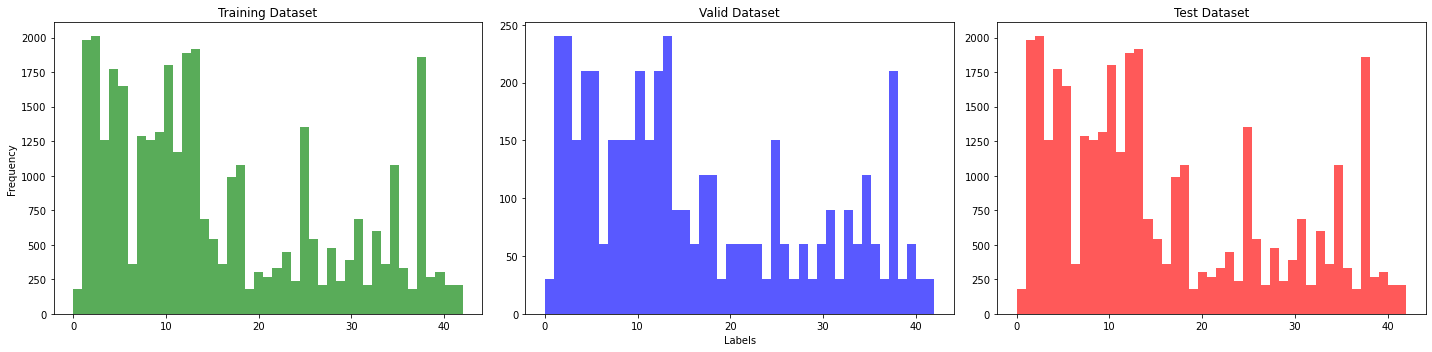

Traffic signs with more examples in datasets



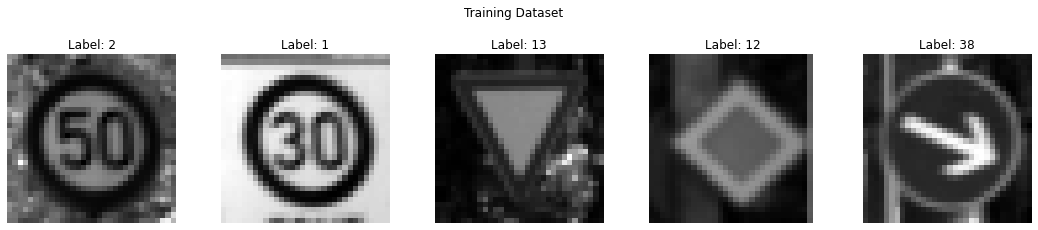

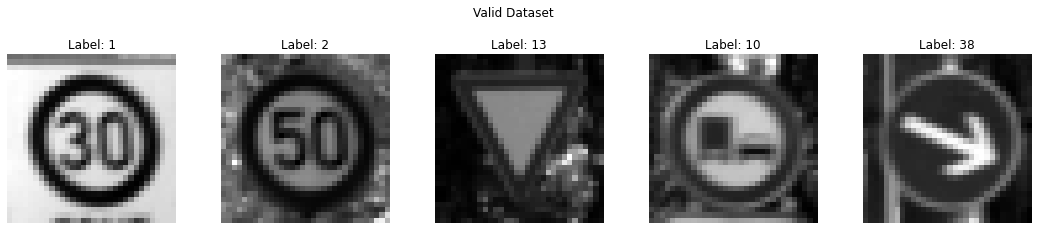

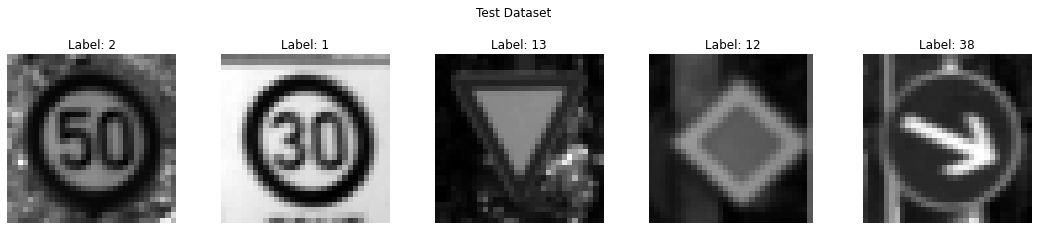

In [31]:
dataset_visualization(X_train_preprocessed,y_train,X_valid_preprocessed,y_valid,X_test_preprocessed,y_train)

In [32]:
#building a CNN model
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(32,32,1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(65,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(43,activation='softmax'))

In [12]:
#summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 65)        18785     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 65)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 65)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [33]:
#compiling the model using Adam optimizer
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [34]:
#early stopping and model checkpoints to save computation effort and time
Earlystopping = EarlyStopping(monitor='val_loss',patience=50,verbose=0,mode='auto',restore_best_weights=True)

filepath= 'D:/deep learning/traffic_signal_classification'

ModelCheckpoint = ModelCheckpoint(filepath = filepath,save_weights_only=True,monitor= 'val_accuracy',mode='auto',save_best_only=True)


In [35]:
#training the model
history = model.fit(X_train_preprocessed,y_train,batch_size=500,epochs=50,verbose=1,validation_data=(X_valid_preprocessed,y_valid))

#evaluating the model performance
eval_score = model.evaluate(X_test_preprocessed,y_test)
print('Accuracy: ',eval_score[1])

history.history.keys()

Epoch 1/50
70/70 [==============================] - 6s 86ms/step - loss: 4.7021 - accuracy: 0.0740 - val_loss: 3.4742 - val_accuracy: 0.1680
Epoch 2/50
70/70 [==============================] - 5s 66ms/step - loss: 2.7709 - accuracy: 0.2876 - val_loss: 2.0921 - val_accuracy: 0.5050
Epoch 3/50
70/70 [==============================] - 5s 67ms/step - loss: 1.4983 - accuracy: 0.5808 - val_loss: 1.0708 - val_accuracy: 0.7138
Epoch 4/50
70/70 [==============================] - 5s 67ms/step - loss: 0.8753 - accuracy: 0.7519 - val_loss: 0.6979 - val_accuracy: 0.8138
Epoch 5/50
70/70 [==============================] - 5s 67ms/step - loss: 0.5595 - accuracy: 0.8450 - val_loss: 0.4688 - val_accuracy: 0.8977
Epoch 6/50
70/70 [==============================] - 5s 67ms/step - loss: 0.4016 - accuracy: 0.8900 - val_loss: 0.3525 - val_accuracy: 0.9197
Epoch 7/50
70/70 [==============================] - 5s 67ms/step - loss: 0.2940 - accuracy: 0.9226 - val_loss: 0.3274 - val_accuracy: 0.9181
Epoch 8/50
70

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
#evaluating the model performance
eval_score = model.evaluate(X_test_preprocessed,y_test)
print('Accuracy: ',eval_score[1])


1088/1088 [==============================] - 5s 4ms/step - loss: 0.0048 - accuracy: 0.9988
Accuracy:  0.9987643361091614


Text(0.5, 0, 'epochs ')

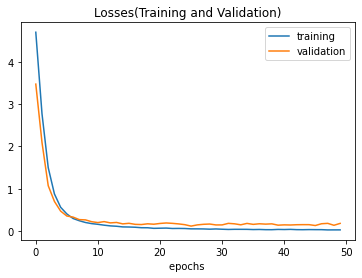

In [37]:
history.history.keys()

#plotting training results

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Losses(Training and Validation)')
plt.xlabel('epochs ')

AttributeError: module 'matplotlib.pyplot' has no attribute 'lengend'

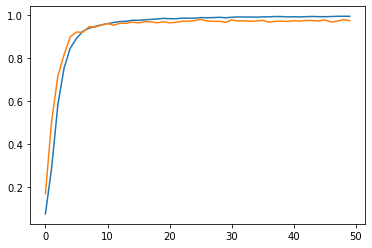

In [38]:
#plotting testing results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.lengend(['training','validation'])
plt.title('Accuracy(Training and validation)')
plt.xlabel('epochs')

Text(0.5, 1.0, 'Prediction=29\n True=29')

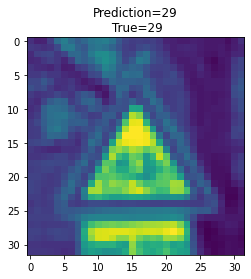

In [44]:
#predicting the new image 
predict = model.predict_classes(X_test_preprocessed)

y_label_true = y_test

#plotting the result with label
i =random.randint(1,len(X_test_preprocessed))
plt.imshow(X_test_preprocessed[i].squeeze())
plt.title('Prediction={}\n True={}'.format(y_label_true[i],predict[i]))